# Cross-validation

This notebooks present how to easily perform cross-validations with ArchPy.
It investigates on the effect of choosing "erode" or "onlap" and how this choice can impact the results of the simulations and the cross-validations.

In [1]:
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
pv.set_jupyter_backend('static')
import sys

sys.path.append("../../")
#my modules
from ArchPy.base import *

In [2]:
P1 = Pile(name = "P1",seed=1)

In [3]:
#grid
sx = 5
sy = 5
sz = 1
x0 = 0
y0 = 0
z0 = -62
nx = 133
ny = 67
nz = 62
x1 = x0 + sx*nx
y1 = y0 + sy*ny

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

In [4]:
## TPG parameters

#flag

t2g1 = 0
t3g1 = 1
t1g2 = -0.3
t2g2 = 3
dic1 = [[(-np.inf,t2g1),(-np.inf,t1g2)],[(t3g1,np.inf),(-np.inf,t2g2)]]
dic2 = [[(-np.inf,t2g1),(t1g2,np.inf)]]
dic3 = [[(t2g1,t3g1),(-np.inf,np.inf)],[(t3g1,np.inf),(t2g2,np.inf)]]

dic = {1:dic1,
       2:dic2,
       3:dic3}

rpk = pfa(dic)
rpk # real facies proportion 


## unconditional and setting variograms
G1 = gcm.CovModel3D(elem=[("cubic",{"w":1.,"r":[100.,50.,20.]}),
                         ("nugget",{"w":0.0})],name="G1")
G2 = gcm.CovModel3D(elem=[("cubic",{"w":1.,"r":[100.,50.,20.]}),
                         ("nugget",{"w":0.0})],name="G2",alpha=60)



In [5]:
#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':130, 'r':[60,60]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':20, 'r':[480, 180]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':160, 'r':[260, 70]})], alpha=30)

## facies covmodel
covmodel_SIS_C = gcm.CovModel3D(elem=[("exponential",{"w":.25,"r":[100,100,30]})],alpha=0,name="vario_SIS") # input variogram
covmodel_SIS_D = gcm.CovModel3D(elem=[("exponential",{"w":.25,"r":[50,50,50]})],alpha=0,name="vario_SIS") # input variogram
lst_covmodelC=[covmodel_SIS_C] # list of covmodels to pass at the function
lst_covmodelD=[covmodel_SIS_D]


#create units 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD, "mean":-10}
dic_f_D = {"f_method" : "TPGs", "G_cm" : [G1, G2], "Flag":dic}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="erode",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-30}
dic_f_C = {"f_method" : "SIS","neig" : 10, "f_covmodel":covmodel_SIS_C}
C = Unit(name="C",order=2,ID = 2,color="blue",contact="onlap",dic_facies=dic_f_C,surface=Surface(dic_surf=dic_s_C,contact="erode"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-30}
dic_f_B = {"f_method":"homogenous"}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

#Master pile
P1.add_unit([D,C,B])

Unit D: Surface added for interpolation
Unit C: covmodel for SIS added
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Stratigraphic unit D added ✅
Stratigraphic unit C added ✅
Stratigraphic unit B added ✅


In [6]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[5,5,1]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[3,3,1]})],alpha=0,name="K_vario_2")
covmodelPoro = gcm.CovModel3D(elem=[("exponential",{"w":0.005,"r":[10,10,10]})],alpha=0,name="poro_vario")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_3 = Facies(ID = 3,name="GM",color="blueviolet")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_6 = Facies(ID = 6,name="Silt",color="goldenrod")

B.add_facies([facies_1,facies_2,facies_3])
D.add_facies([facies_1,facies_2,facies_3])
C.add_facies([facies_4,facies_6])
    
permea = Prop("K",[facies_1,facies_2,facies_3,facies_4,facies_6],
                  [covmodelK2,covmodelK,covmodelK,None,covmodelK],
                  means=[-3.5,-2,-4.5,-8,-5.5,-6.5,-10],
                  int_method = ["sgs","sgs","sgs","homogenous","sgs","sgs","homogenous"],
                  def_mean=-5)

Facies Sand added to unit B ✅
Facies Gravel added to unit B ✅
Facies GM added to unit B ✅
Facies Sand added to unit D ✅
Facies Gravel added to unit D ✅
Facies GM added to unit D ✅
Facies Clay added to unit C ✅
Facies Silt added to unit C ✅


In [7]:
T1 = Arch_table(name = "P1",seed=1)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin)
T1.add_prop([permea])

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added


In [8]:
T1.process_bhs()

##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set
No borehole found - no hd extracted


In [9]:
T1.compute_surf(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT B
simulate2D: WARNING: deprecated function, use function `simulate` instead
B: time elapsed for computing surface 0.07755899429321289 s

#### COMPUTING SURFACE OF UNIT C
simulate2D: WARNING: deprecated function, use function `simulate` instead
C: time elapsed for computing surface 0.07716727256774902 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.01213383674621582 s
##########################


### 0.17723608016967773: Total time elapsed for computing surfaces ###


In [10]:
import warnings
warnings.filterwarnings("ignore")

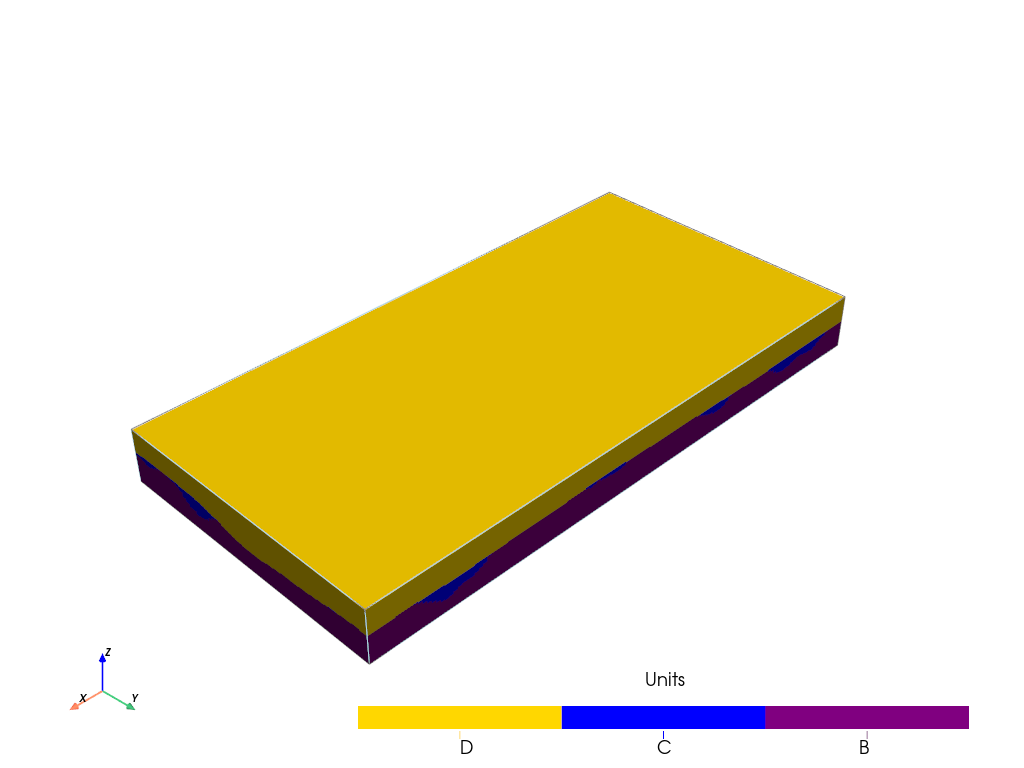

In [11]:
T1.plot_units()

In [12]:
hd, facies = T1.hd_fa_in_unit(C, iu=0)
facies == 2

False

In [13]:
T1.compute_facies(1)


### Unit D: facies simulation with TPGs method ####
### Unit D - realization 0 ###


Time elapsed 1.19 s

### Unit C: facies simulation with SIS method ####
### Unit C - realization 0 ###
Only one facies covmodels for multiples facies, adapt sill to right proportions


Time elapsed 0.49 s

### Unit B: facies simulation with homogenous method ####
### Unit B - realization 0 ###
WARNING !! More than one facies has been passed to homogenous unit B
First in the list is taken
Time elapsed 0.0 s

### 1.68: Total time elapsed for computing facies ###


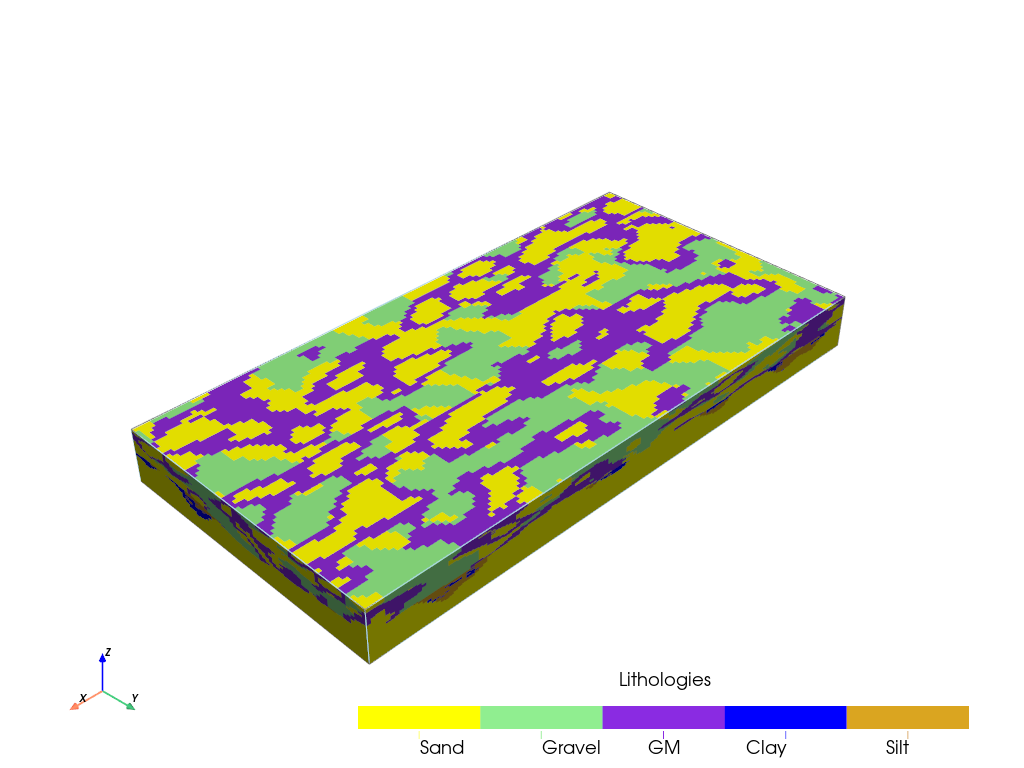

In [14]:
T1.plot_facies()

In [15]:
T1.rem_all_bhs()

Standard boreholes removed
Fake boreholes removed
Geological map boreholes removed


In [16]:
np.random.seed(115)
n=20

x_positions=(np.random.random(size=n) - x0)*x1
y_positions=(np.random.random(size=n) - y0)*y1
l_bhs=T1.make_fake_bh(x_positions, y_positions)[0][0]

In [17]:
T1.add_bh(l_bhs)

Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Borehole fake goes below model limits, borehole fake depth cut
Borehole fake added
Bore

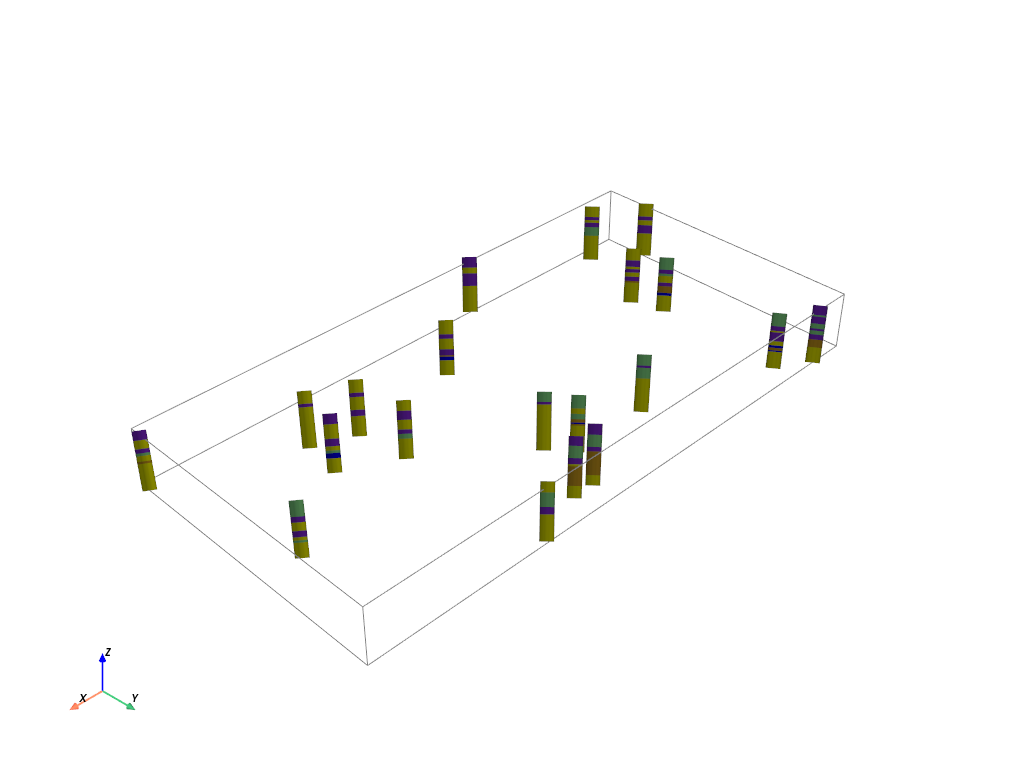

In [18]:
T1.plot_bhs("facies")

## Cross-validation

Let's modify the contact to "onlap" and perform a cross-validation

In [19]:
T1_copy = copy.deepcopy(T1)
T1_copy.list_all_units[1].surface.contact = "onlap"

In [20]:
import ArchPy.x_valid

simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
fake


fake
fake
fake
fake
fake


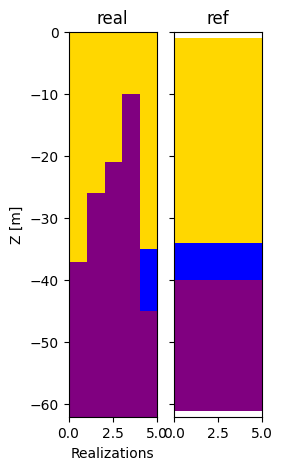

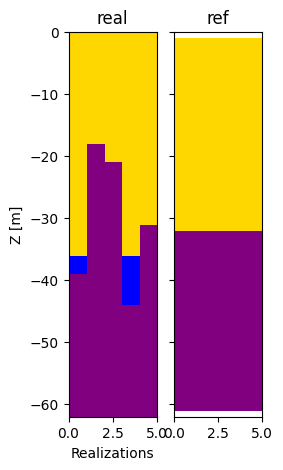

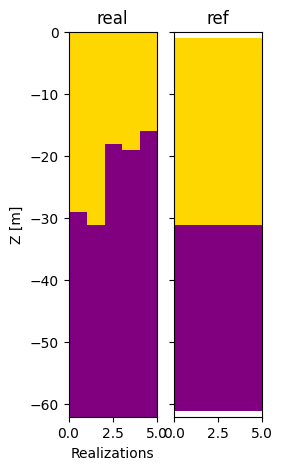

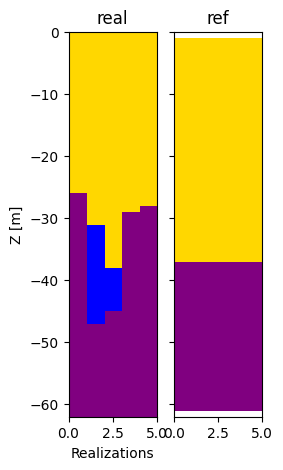

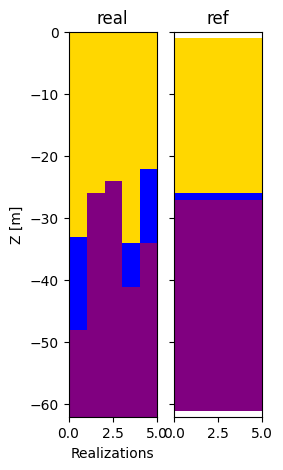

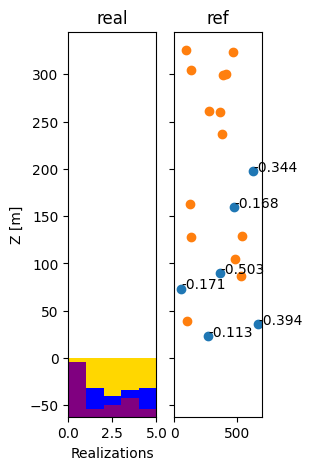

simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
fake
fake
fake
fake
fake
fake


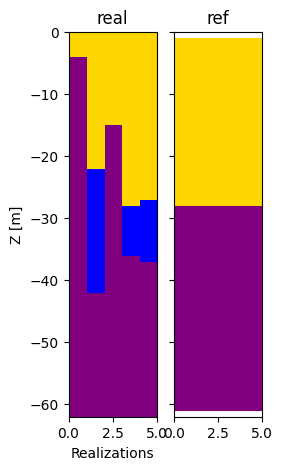

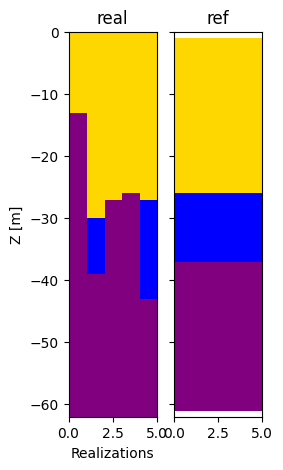

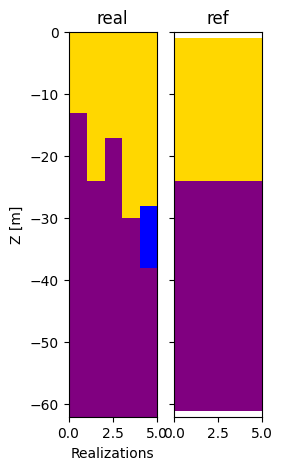

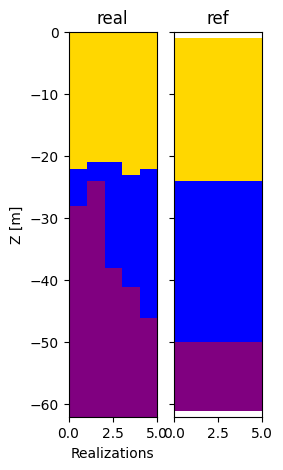

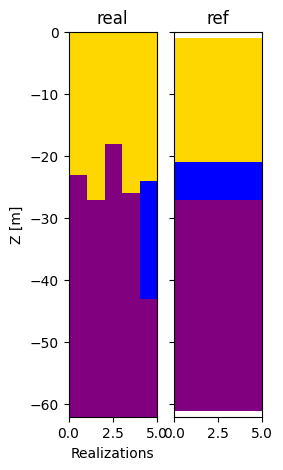

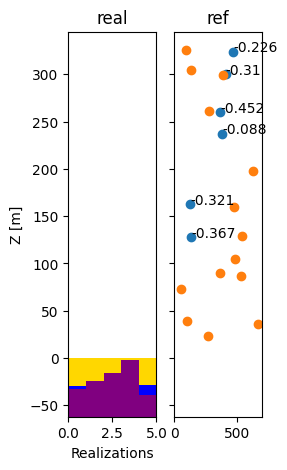

simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


fake
fake
fake
fake
fake
fake


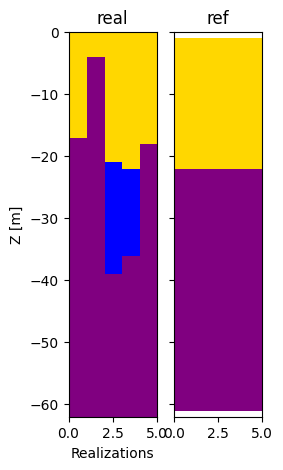

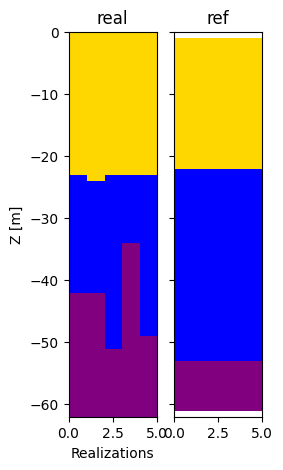

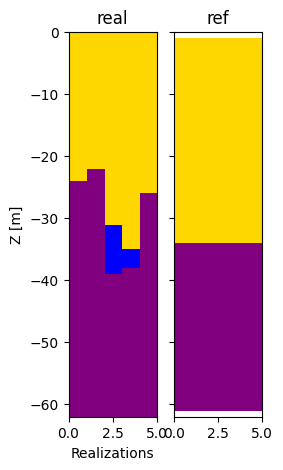

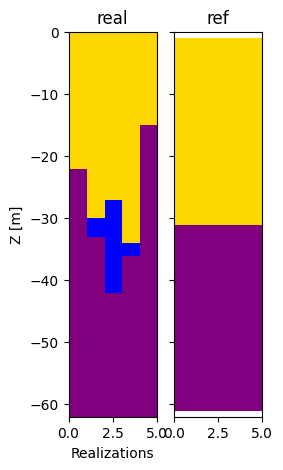

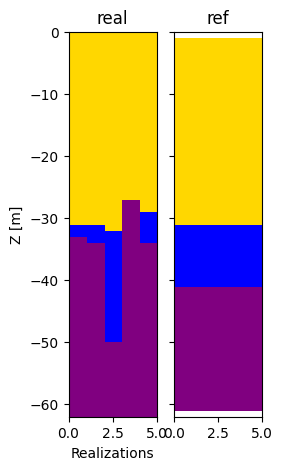

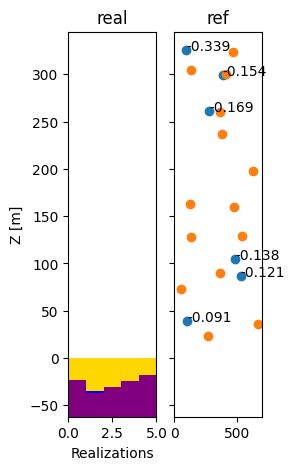

@@@ CONFUSION MATRIX: UNITS @@@ 



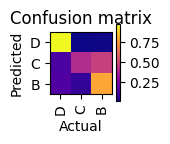

CPU times: total: 1min 11s
Wall time: 4.67 s


In [21]:
%%time
scores = ArchPy.x_valid.X_valid(T1_copy, k=3, nreal_un=5, nreal_fa=0, seed=230,
                                weighting_method="same_weights", plot=True, verbose=0)

In [22]:
print(np.mean([i['final brier score units'] for i in scores[0][:][:, 0]]))

-0.24825015040601342


The score shown is a weighted mean of the brier score compute on all the boreholes.

Let's now set back the contact type to "erode" and observe the results

In [23]:
T1_copy = copy.deepcopy(T1)
T1_copy.list_all_units[1].surface.contact = "erode"

simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


fake
fake


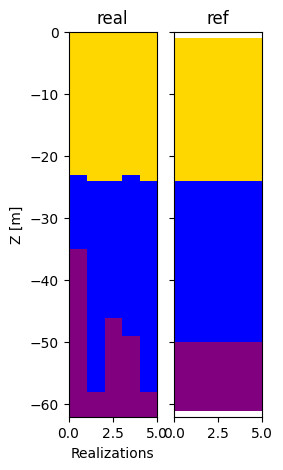

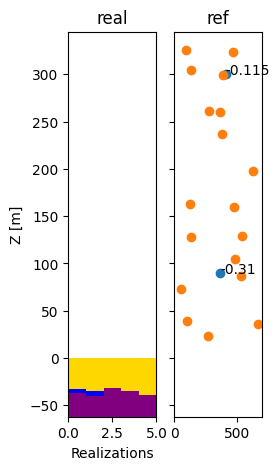

simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
fake
fake


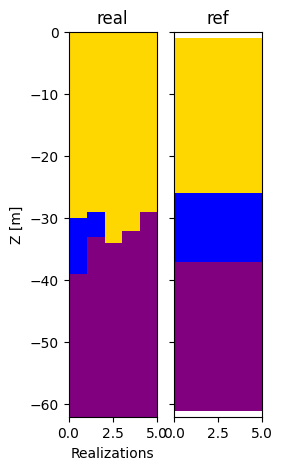

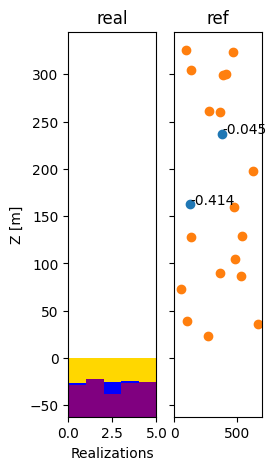

simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
fake
fake


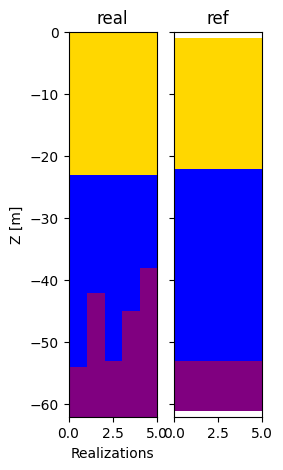

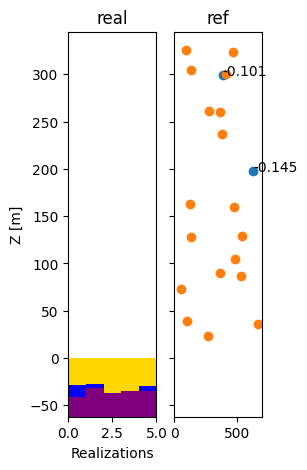

simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
fake
fake


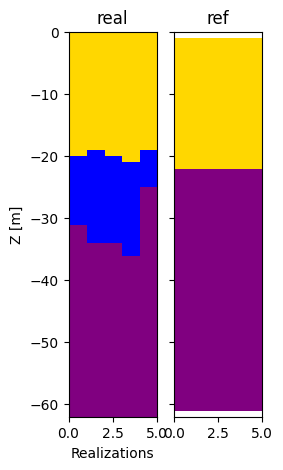

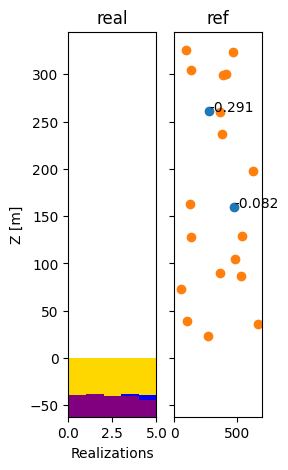

simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
fake
fake


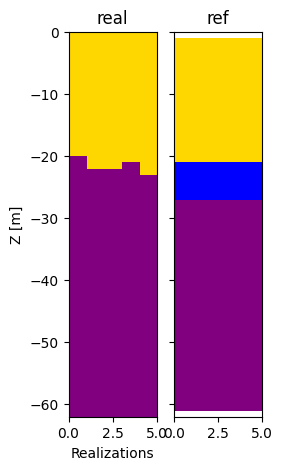

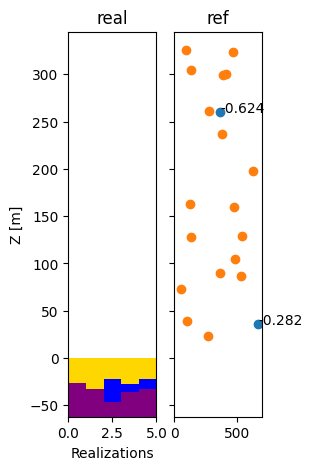

simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
fake
fake


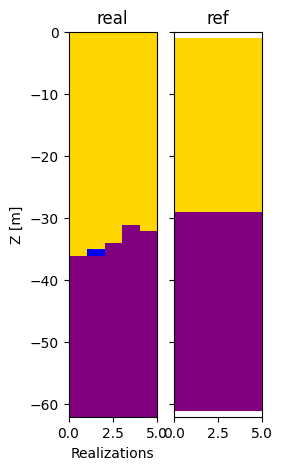

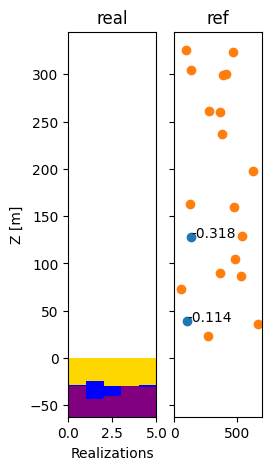

simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead
simulate2D: WARNING: deprecated function, use function `simulate` instead


simulate2D: WARNING: deprecated function, use function `simulate` instead
fake
fake


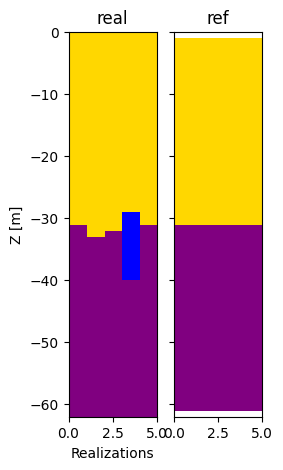

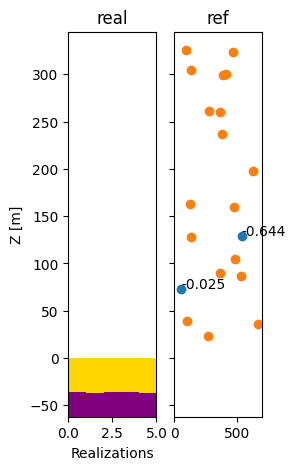

@@@ CONFUSION MATRIX: UNITS @@@ 



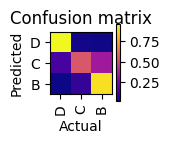

In [24]:
scores = ArchPy.x_valid.X_valid(T1_copy, k=7, nreal_un=5, nreal_fa=0, seed=10, plot=True, verbose=0)

In [25]:
print(np.mean([i['final brier score units'] for i in scores[0][:][:, 0]]))

-0.25060766965150727


The scores is (slightly) higher (as expected !)